In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
import matplotlib.pyplot as plt

import trecs
from trecs.models import ImplicitMF, ImplicitMFLFD
from trecs.random import Generator
from trecs.metrics import MSEMeasurement, AverageFeatureScoreRange


In [2]:
mf = ImplicitMF(num_users=100, num_items=500, num_latent_factors=20, 
                num_items_per_iter=10)
mf.add_metrics(MSEMeasurement())
mf.add_metrics(AverageFeatureScoreRange())
mf.startup_and_train(20)
mf.run(timesteps=50, train_between_steps=True, reset_interactions=False)

100%|██████████| 20/20 [00:00<00:00, 117.91it/s]
/Users/amywinecoff/Documents/CITP/Research/Github/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 50/50 [00:04<00:00, 12.39it/s]


In [3]:
mflfd.top_n_limit

NameError: name 'mflfd' is not defined

In [4]:
mflfd = ImplicitMFLFD(num_users=200, num_items=50, num_latent_factors=20)
mflfd.add_metrics(MSEMeasurement())

100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


In [5]:
mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
mflfd_afsr= mflfd_metrics['afsr'].to_list()#[21:]

mf_metrics = pd.DataFrame(mf.get_measurements())
mf_afsr= mf_metrics['afsr'].to_list()#[21:]


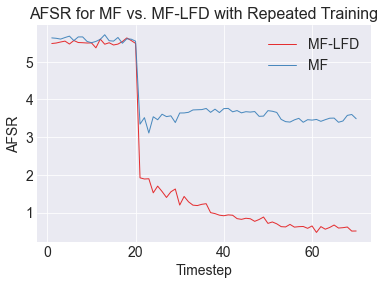

In [6]:
# style
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})

# create a color palette
palette = plt.get_cmap('Set1')

plt.plot(list(range(len(mflfd_afsr))), mflfd_afsr, marker='', color=palette(0), linewidth=1, alpha=0.9, label='MF-LFD')
plt.plot(list(range(len(mf_afsr))), mf_afsr, marker='', color=palette(1), linewidth=1, alpha=0.9, label='MF')

# Add legend
#plt.legend(loc=2, ncol=2)
plt.legend(loc=1, ncol=1)

# Add titles
plt.title("AFSR for MF vs. MF-LFD with Repeated Training", loc='center', fontsize=16, fontweight=2)
plt.xlabel("Timestep")
plt.ylabel("AFSR")
plt.show()



In [ ]:
mflfd_metrics.head(40)